## load up and package data for a model run

In [1]:
version_number =  '0p2'

In [2]:
import pickle
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from time import time
from glob import glob
from scipy.io import loadmat
from PIL import Image
from scipy.stats import pearsonr
from hrf_fitting.src.feature_weighted_rf_models import make_rf_table,receptive_fields, model_space, prediction_menu,bigmult
from hrf_fitting.src.feature_weighted_rf_models import train_fwrf_model
from hrf_fitting.src.gabor_feature_dictionaries import gabor_feature_maps
from os.path import join

Using gpu device 0: GeForce GTX TITAN X


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Step 0: load up pre-trained model

In [4]:
saving_place = '/media/tnaselar/Data/deepnet_vim-1/feature_weighted_models/'
saving_file = 'model_space_'+version_number+'.p'

ms = pickle.load(open( join(saving_place, saving_file), "r"))


### Step 0: Load crcns feature maps

In [5]:
##known stimulus parameters
Ttrn = 1750
Tval = 120

##don't use these
junk_keys = ['__header__', '__globals__', '__version__', 'fc6', 'fc7', 'fc8','prob']

##this is > 8GB
deepnet_trn_feature_dict = loadmat('/media/tnaselar/Data/deepnet_vim-1/vim-1_trn_response.mat')
##it contains some key/value pairs we don't want

deepnet_trn_feature_dict = {key: value.astype('float32') for key, value in deepnet_trn_feature_dict.items() if key not in junk_keys}
print deepnet_trn_feature_dict.keys()

##much smaller
deepnet_val_feature_dict = loadmat('/media/tnaselar/Data/deepnet_vim-1/vim-1_val_response.mat')
##it contains some key/value pairs we don't want
deepnet_val_feature_dict = {key: value.astype('float32') for key, value in deepnet_val_feature_dict.items() if key not in junk_keys}
print deepnet_val_feature_dict.keys()


['conv3', 'conv2', 'conv1', 'conv5', 'conv4']
['conv3', 'conv2', 'conv1', 'conv5', 'conv4']


### Step 2: receptive fields

In [6]:
# deg_per_stimulus = 20
# deg_per_radius = (.75, 8., 6) ##rf sizes in degrees (smallest, largest, number of sizes)
# spacing = 1.5 ##spacing between rf's in degrees
# rf = receptive_fields(deg_per_stimulus,deg_per_radius,spacing)

In [7]:
# rf.rf_table['deg_per_radius'].unique()

In [8]:
# print 'G = number of rf models = %d' %(rf.rf_table.shape[0])

#### construct training/validation model space tensors

In [9]:
##validation data
val_mst = ms.construct_model_space_tensor(deepnet_val_feature_dict)

-----------feature: conv3
at pixel resolution 13 the following rfs will default to 0: (array([ 0.75]),)
-----------feature: conv2
-----------feature: conv1
-----------feature: conv5
at pixel resolution 13 the following rfs will default to 0: (array([ 0.75]),)
-----------feature: conv4
at pixel resolution 13 the following rfs will default to 0: (array([ 0.75]),)
converted nans to nums
model_space_tensor has been z-scored


In [10]:
del deepnet_val_feature_dict

### Step 4: load and package crcns voxel data

In [11]:
voxel_file = '/media/tnaselar/Data/crcns_datasets/vim-1/EstimatedResponses.mat'
crcns_voxel_data = h5py.File(voxel_file,'r')
crcns_voxel_data.keys()

[u'dataTrnS1',
 u'dataTrnS2',
 u'dataValS1',
 u'dataValS2',
 u'roiS1',
 u'roiS2',
 u'voxIdxS1',
 u'voxIdxS2']

#### concatenate val/trn and remove nans
A few thousand voxels have missing obersvations, remove them because even one nan will infect gradient for every voxel.

In [12]:
##concatenate 
voxel_data = np.concatenate((crcns_voxel_data['dataValS1'],crcns_voxel_data['dataTrnS1']),axis=0).astype('float32')
V_orig = voxel_data.shape[1]


no_nan = np.isnan(voxel_data).sum(axis=0) == 0 ##<<only pulled voxels with nans in training data, should pull if nans in val data too.
voxel_data = voxel_data[:,no_nan]
print voxel_data.shape
V = voxel_data.shape[1] ##should be 25915
vox_idx = np.arange(0,V_orig)[no_nan]


(1870, 22701)


(22701,)


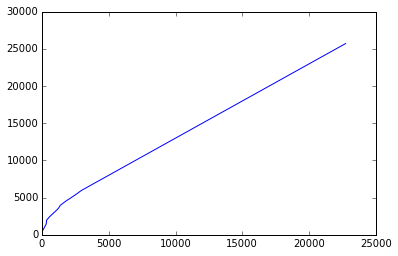

In [13]:
print vox_idx.shape
plt.plot(vox_idx)

In [14]:
crcns_voxel_data.close()

#### get training/validation views on voxel_data

In [15]:
T = Tval+Ttrn
nvox= V
trnIdx = np.arange(Tval,T)
valIdx = np.arange(0,Tval)
trn_voxel_data = voxel_data[trnIdx,0:nvox]


#### prediction accuracy for all voxels

In [16]:
##grab validation data
val_voxel_data = voxel_data[valIdx,0:nvox]

In [17]:
##generate predictions
# pred = prediction_menu(val_mst, ffw[np.newaxis,:,:], rf_indices = frf) ##<<too big, choked. 


##generate predictions one voxel at a time
pred = np.zeros((Tval,nvox))
for v in range(nvox):  ##FIXED ! ?<<some kind of bug in training function, last voxel getting skipped...th
    pred[:,v] = np.squeeze(bigmult(val_mst[np.newaxis,ms.optimal_rf_model[v],:,:],
                                   ms.optimal_feature_weights[np.newaxis,:,v, np.newaxis]))

In [18]:
##get correlation = prediction accuracy
val_cc = np.zeros(nvox)  
for v in range(nvox): 
    val_cc[v] = pearsonr(val_voxel_data[:,v],pred[:,v])[0]
val_cc = np.nan_to_num(val_cc)

(-0.4, 0.9)

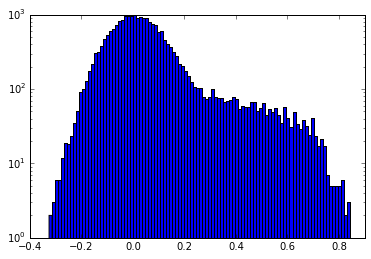

In [19]:
##histogram of prediction accuracy, all voxels
_=plt.hist(val_cc,100)
plt.yscale('log')
plt.ylim([10**0, 10**3])
plt.xlim([-.4, 0.9])

In [20]:
np.sum(map(lambda x: x > 0.2, val_cc))

2973

#### area-wise prediction accuracy

In [21]:
##get position information. need to re-open file
voxel_file = '/media/tnaselar/Data/crcns_datasets/vim-1/EstimatedResponses.mat'
crcns_voxel_data = h5py.File(voxel_file,'r')

vox_position = crcns_voxel_data['voxIdxS1'][0,no_nan]  ##index into a 64 x 64 x 18 volume (matlab-style raveling)

##get the indices for visual areas
roi_indicator = crcns_voxel_data['roiS1'][0, no_nan]
roi_names = ['other', 'v1', 'v2', 'v3', 'v3A', 'v3B', 'v4', 'LO']

crcns_voxel_data.close()

In [22]:
##area-wise prediction accuracy
areawise_accuracy = []
for ii,roi in enumerate(roi_names):
    voxels_in_roi = roi_indicator == ii
    areawise_accuracy.append(np.array(val_cc)[voxels_in_roi])

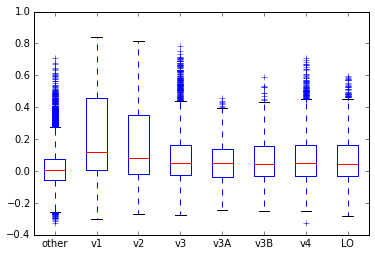

In [23]:
_=plt.boxplot(areawise_accuracy,labels = roi_names)

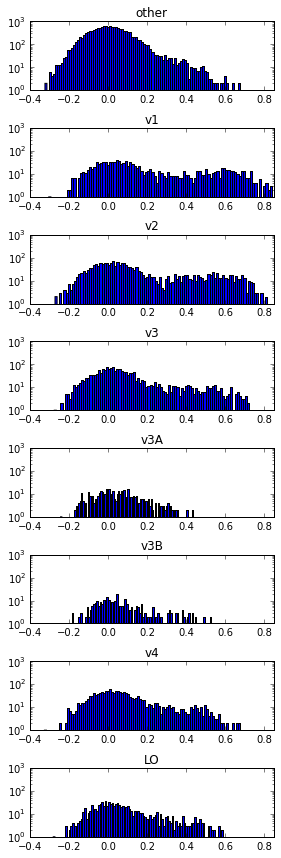

In [26]:
n_rois = len(roi_names)
fig = plt.figure(figsize = (4,12))
for ii,roi in enumerate(roi_names):
    plt.subplot(n_rois,1,ii+1)
    plt.hist(areawise_accuracy[ii],100)
    plt.yscale('log')
    plt.xlim([-0.4, 0.85])
    plt.ylim([0, 10**3])
    plt.title(roi)
plt.tight_layout()  

In [28]:
f = open(join(saving_place,'refnet_areawise_prediction_accuracy.p'),'w')
pickle.dump([roi_names, areawise_accuracy], f)
f.close()

In [29]:
f = open(join(saving_place,'refnet_areawise_prediction_accuracy.p'),'r')
foo = pickle.load(f)
f.close()

In [30]:
f

<closed file '/media/tnaselar/Data/deepnet_vim-1/feature_weighted_models/refnet_areawise_prediction_accuracy.p', mode 'r' at 0x7f1c26107390>